# Homework Assignment 6: Deep Q Learning <a class="tocSkip">

This weeks homework assignment is build a deep q network to defeat the [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) environment in OpenAI’s Gym environment. Use this [repository](https://github.com/AndersonJo/dqn-pytorch) as a helpful guide. Train it and test it, if your algorithm successfully learns how to beat the environment, you’ve successfully completed the assignment. Good luck!

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Exercise" data-toc-modified-id="Exercise-1">Exercise</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Network-design" data-toc-modified-id="Network-design-1.0.1">Network design</a></span></li><li><span><a href="#Agent-Design" data-toc-modified-id="Agent-Design-1.0.2">Agent Design</a></span></li><li><span><a href="#Construct-evaluate" data-toc-modified-id="Construct-evaluate-1.0.3">Construct evaluate</a></span></li><li><span><a href="#Experience-Replay" data-toc-modified-id="Experience-Replay-1.0.4">Experience Replay</a></span></li><li><span><a href="#Learning-with...-Q-learning" data-toc-modified-id="Learning-with...-Q-learning-1.0.5">Learning with... Q-learning</a></span></li><li><span><a href="#Main-Loop" data-toc-modified-id="Main-Loop-1.0.6">Main Loop</a></span></li><li><span><a href="#Continuing-with-CPU" data-toc-modified-id="Continuing-with-CPU-1.0.7">Continuing with CPU</a></span></li></ul></li></ul></li><li><span><a href="#Research" data-toc-modified-id="Research-2">Research</a></span></li><li><span><a href="#Big-Questions" data-toc-modified-id="Big-Questions-3">Big Questions</a></span></li><li><span><a href="#Resources" data-toc-modified-id="Resources-4">Resources</a></span></li></ul></div>

# Exercise

This version utilizes a Convolutional Neural Network.

In [1]:
# imports
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline

import torch
torch.set_default_tensor_type('torch.cuda.FloatTensor')

import torch.nn as nn
import torch.nn.functional as F

USE_CPU = False # can be True or False
GPU = 1 # can be 0 or 1
   

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


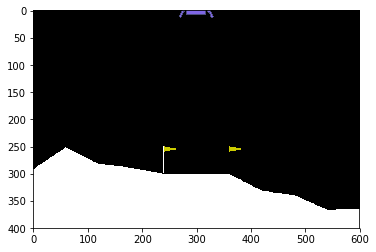

In [2]:
env = gym.make("LunarLander-v2")
env.reset()
img = env.render(mode='rgb_array')
env.close()
plt.imshow(img)

### Network design

1. the data within the model will move through the layers
2. the "forward" method will pull our 'x' through the layers and then apply ReLU functions to keep our values positive
3. $ input (x) -> layer_1 -> ReLU -> layer_2 -> ReLU -> output $

In [3]:
class DQNModel(nn.Module):
    
    def __init__(self, input_size, output_size):
        super(DQNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.head = nn.Linear(448, output_size)
        
        # self.layer1 = nn.Linear(input_size, 64)
        # self.layer2 = nn.Linear(64,128)
        # self.output = nn.Linear(128, output_size)
    
    def forward(self, x):
        x = x.float() # matmul requires tensors of type float
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))       
        x = F.relu(self.bn3(self.conv3(x)))               
        """ original
        x = self.layer1(x)
        x = F.relu(x)
        x = F.relu(self.layer2(x))
        """
        return self.output(x)

### Agent Design

    

In [4]:

class DQNAgent:
    def __init__(self, state_shape, n_actions, model, epsilon=0):
        """Doc-string"""
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape
        self.model = model #can accept different models
        
    def get_q_values(self, state):
        """
        state: observation from gym environment
        pytorch needs [batch, s], so add a batch dim in state
        """
        
        if torch.cuda.is_available() and not USE_CPU:
            device = torch.device(f"cuda:{GPU}")
        else:
            device = torch.device("cpu")
            
        expanded_state = np.expand_dims(state, axis=0)
        print(f"Expanded state: {expanded_state}")
        s = torch.from_numpy(expanded_state).to(device)

        with torch.no_grad():
            q = self.model.forward(s)
       
        squeezed = torch.squeeze(q.data)

        return squeezed
    
    def sample_action(self, q_values):
        """pick actions given q_values.  Uses epsilon-greedy exploration strategy
        suppose self.epsilon = 0.5
        suppose self.n_actions = 5
        line 31: p = [0.1, 0.1, 0.1, 0.1, 0.1]
        suppose q_values = [1.0, 2.0, 10.0, 3.0, 4.0]
        then q_values.argmax(axis=-1) = 2 #counting from 0
        then on line 32:
        p[2] += (1 - self.epsilon) or p[2] += 0.5 or p[2] = 0.1 + 0.5 = 0.6
        so now
        p = [0.1, 0.1, 0.6, 0.1, 0.1]
        """       
        p = np.ones(self.n_actions, dtype=np.float) * self.epsilon / self.n_actions
        #p[q_values.argmax(axis=-1)] += 1 - self.epsilon
        p[torch.argmax(q_values)] += 1 - self.epsilon
        action = np.random.choice(n_actions, p=p)
        return action

        

### Construct evaluate

In [5]:
def evaluate(env, agent, n_games=1, greedy=True):
    """Plays n_games full games.  If greedy, picks actions as argmax(q_values).
    Returns mean reward. """
    t_max = env.spec.timestep_limit or 10000 # maximum_timesteps
    rewards = []
    old_epsilon = agent.epsilon
    if greedy:
        agent.epsilon = 0.0 # take the best move according to q_values
        
    for _ in range(n_games):
        s = env.reset()
        # print(f"type(s): {type(s)}")
        reward = 0
        for _ in range(t_max):
            q_values = agent.get_q_values(s)
            action = agent.sample_action(q_values)
            s, r, done, _ = env.step(action)
            reward += r
            if done: break
                
        rewards.append(reward)
        
    agent.epsilon = old_epsilon
    
    return np.mean(rewards) # we could also have just said mean(rewards)



### Experience Replay

**The interface:**

- `exp_replay.push(state, action, reward, next_state, done)`
    - saves (s, a, r, s', done) tuple into the buffer
- `exp_replay.sample(batch_size)`
    - returns observations, actions, rewards, next_observations, and is_done for batch_size random samples
- `len(exp_replay)`
    - returns number of elements stored in the replay buffer

In [6]:
import random
from collections import namedtuple

Transition = namedtuple(
    'Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayMemory(object):
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        
    def push(self, *args):
        """Saves a transition"""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def head(self):
        return self.memory[-1]
    
    def __len__(self):
        return len(self.memory)
    
            


### Learning with... Q-learning

In [7]:
def td_loss(target_net, policy_net, states, actions, rewards, next_states, is_dones, GAMMA=0.99):
    device = None
    if torch.cuda.is_available() and not USE_CPU: #if we want to use a GPU
        device = GPU 
    else:
        device = "cpu"
    s_ = torch.as_tensor(states, device=device)
    a_ = torch.as_tensor(actions, device=device)
    r_ = torch.as_tensor(rewards, device=device)
    # ns_ = torch.as_tensor(next_states, device=device)
    d_ = torch.as_tensor(is_dones, device=device)
    not_d_ = 1 - d_

    #predict Q values
    predict_q_ = policy_net(s_).gather(dim=1, index=a_.view(-1, 1)).squeeze()
    
    #predict Next Q Values with target network
    with torch.no_grad():
        predict_next_q_ = target_net(s_)
        predict_v_ = torch.max(predict_next_q_, dim=1)[0] * not_d_
        reference_q_ = r_ + GAMMA * predict_v_
        
    loss = F.mse_loss(predict_q_, reference_q_)
    
    return loss
    

### Main Loop

Let's roll

In [8]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

mean_rw_history = []
td_loss_history = []
td_loss_m_history = []
BATCH_SIZE = 64
TIME_STEPS = 2*10**5
LEARNING_RATE = 0.0001 #0.0001


In [9]:
device = None
if torch.cuda.is_available() and not USE_CPU:
    device = torch.device(f"cuda:{GPU}")
else:
    device = torch.device("cpu")
    print("Using cpu device")
    

state_dim, n_actions = env.observation_space.shape[0], env.action_space.n

In [10]:
print(device)
policy_net = DQNModel(state_dim, n_actions).to(device)
target_net = DQNModel(state_dim, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
agent = DQNAgent(state_dim, n_actions, policy_net, epsilon=0.5)
exp_replay = ReplayMemory(10**4)

cuda:1


In [11]:
evaluate(env, agent, n_games=3)

Expanded state: [[-0.004597    0.93871413 -0.4656394  -0.12662746  0.00533353  0.10547423
   0.          0.        ]]


RuntimeError: Expected 4-dimensional input for 4-dimensional weight [16, 3, 5, 5], but got input of size [1, 8] instead

### Continuing with CPU

In [ ]:
optimizer = torch.optim.Adam(policy_net.parameters(),lr=LEARNING_RATE)

#for training
env = gym.make("LunarLander-v2")
#for evaluation
eval_env = gym.make("LunarLander-v2")
s = env.reset()

for i in trange(TIME_STEPS):
    # play
    q_values = agent.get_q_values(s)
    a = agent.sample_action(q_values)
    s_next, r, done, _ = env.step(a)
    
    exp_replay.push(s, a, r, s_next, done)
    
    s = s_next
    
    if done:
        s = env.reset()
        
    if len(exp_replay) < BATCH_SIZE:
        continue
        
    # train
    # < sample data from experience replay >
    transitions = exp_replay.sample(BATCH_SIZE)
    # transpose the batch
    batch = Transition(*zip(*transitions))
    
    # loss = < compute TD loss >
    nd_states = np.array(batch.state, dtype=np.float32)
    nd_actions = np.array(batch.action, dtype=np.int64)
    nd_rewards = np.array(batch.reward, dtype=np.float32)
    nd_next_states = np.array(batch.next_state, dtype=np.float32)
    nd_is_dones = np.array(batch.done).astype(np.float32)
    
    loss = td_loss(target_net, policy_net, nd_states, nd_actions, nd_rewards, nd_next_states, nd_is_dones)
    
    # <minimize loss by gradient descent>
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
    loss_data = loss.data
    if torch.cuda.is_available() and not USE_CPU:
        loss_data = loss.data.cpu()

    td_loss_history.append(loss_data.numpy())
    count = min(len(td_loss_history), 100)
    
    td_loss_m_history.append(np.mean(td_loss_history[-count:]))
  
    # adjust agent parameters
    if i % 500 == 0:
        agent.epsilon = max(agent.epsilon * 0.99, 0.01)
        
        mean_rw_history.append(evaluate(eval_env, agent, n_games=3))
    
        #Load agent weights into target_network
        target_net.load_state_dict(policy_net.state_dict())
    
        clear_output(True)
        print(f"buffer size = {len(exp_replay)}, epsilon = {agent.epsilon:2.5}")
        plt.figure(figsize=[12, 4])
        plt.subplot(1, 2, 1)
        plt.title("mean reward per game")
        plt.plot(mean_rw_history)
        plt.grid()

        plt.subplot(1, 2, 2)
        plt.title("TD loss history (moving average)")
        plt.plot(td_loss_m_history)
        plt.grid()
        plt.show()

# Research

In [ ]:
import torch

In [ ]:
dir(torch)

In [ ]:
print(type(torch.device))

In [ ]:
torch.cuda.device_count()

In [ ]:
torch.cuda.get_device_name(0)

In [ ]:
torch.cuda.get_device_name(1)

In [ ]:
device = torch.device("cuda:1")

In [ ]:
print(device)

In [ ]:
torch.cuda.is_available()

In [ ]:
torch.cuda.device_ctx_manager(0)

---

# Big Questions

1.  Are we copying data from cpu tensors to gpu tensors in our Model class?

# Resources

- [Github 1](https://github.com/etendue/move37/blob/master/dqn_box2d.ipynb)
- [Github 2](https://github.com/johannesharmse/move_37_course/blob/master/src/dqn/lunar_land.py)